#### Starbucks locations in washington DC

Suppose we are a supplier and we want to supply coffee beans to starbucks locations inside DC. we will use route optimization techniques to find the best possible route to visit all the store locations exactly once and go back to the original home node. this is an extension on the TSP problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import geopy.distance #to measure the actual distance between osmnx graph nodes and points in google maps

#for network and graph analysis
import networkx as nx
import osmnx as ox

#filter warnings
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
df = pd.read_csv('data_stores.csv')

state = 'DC'
city = 'Washington'
country = 'US'

In [3]:
df_local = df[(df['State/Province']==state) &
               (df['City'] == city) & 
               (df['Country']==country) & 
               (df['Brand'] == 'Starbucks')]\
                [['Street Address','Longitude', 'Latitude']].sample(frac=1).reset_index(drop=True)

df_local = df_local.drop_duplicates((['Longitude','Latitude']),keep='first').reset_index().rename(columns={'index':'id','Street Address':'address', 'Latitude':'y', 'Longitude':'x'})
df_local.reset_index(inplace=True)
df_local.drop(columns=['id'],inplace=True)
df_local.head()

,index,address,x,y
0,0,"470 L'Enfant Plaza East, SW, 812, Foxhall Square",-77.02,38.88
1,1,2302 Wisconsin Ave NW,-77.07,38.92
2,2,3800 Reservoir Road,-77.07,38.91
3,3,"40 Massachusetts Ave NE, 169, Main Hall",-77.01,38.90
4,4,2109 M Street NW,-77.05,38.91


In [4]:
data = df_local.copy()

In [5]:
data.head(3)

,index,address,x,y
0,0,"470 L'Enfant Plaza East, SW, 812, Foxhall Square",-77.02,38.88
1,1,2302 Wisconsin Ave NW,-77.07,38.92
2,2,3800 Reservoir Road,-77.07,38.91


In [6]:
data['color'] = ''
data.loc[data['index'] == 0, 'color'] = 'red'
data.loc[data['index'] != 0, 'color'] = 'black'

start = data[data['index'] == 0][['y','x']].values[0]

#print(start)
data.head(3)

,index,address,x,y,color
0,0,"470 L'Enfant Plaza East, SW, 812, Foxhall Square",-77.02,38.88,red
1,1,2302 Wisconsin Ave NW,-77.07,38.92,black
2,2,3800 Reservoir Road,-77.07,38.91,black


In [7]:
# create a map of DC - starting from the first starbucks location
map = folium.Map(
    location= start,
    titles = 'carthodbpositron',
    zoom_start=12
)

# create indictators for starbucks stores on the map using a colored circle
data.apply( lambda row:
           folium.CircleMarker(location= [row['y'],row['x']],
                               color = row['color'],
                               fill = True,
                               radius=2.5).add_to(map),axis=1

)

map

#### Creating graphs with nodes and edges

so here  I will use open street maps networkx to create a network (graph) of all the possible routes between starbucks stores

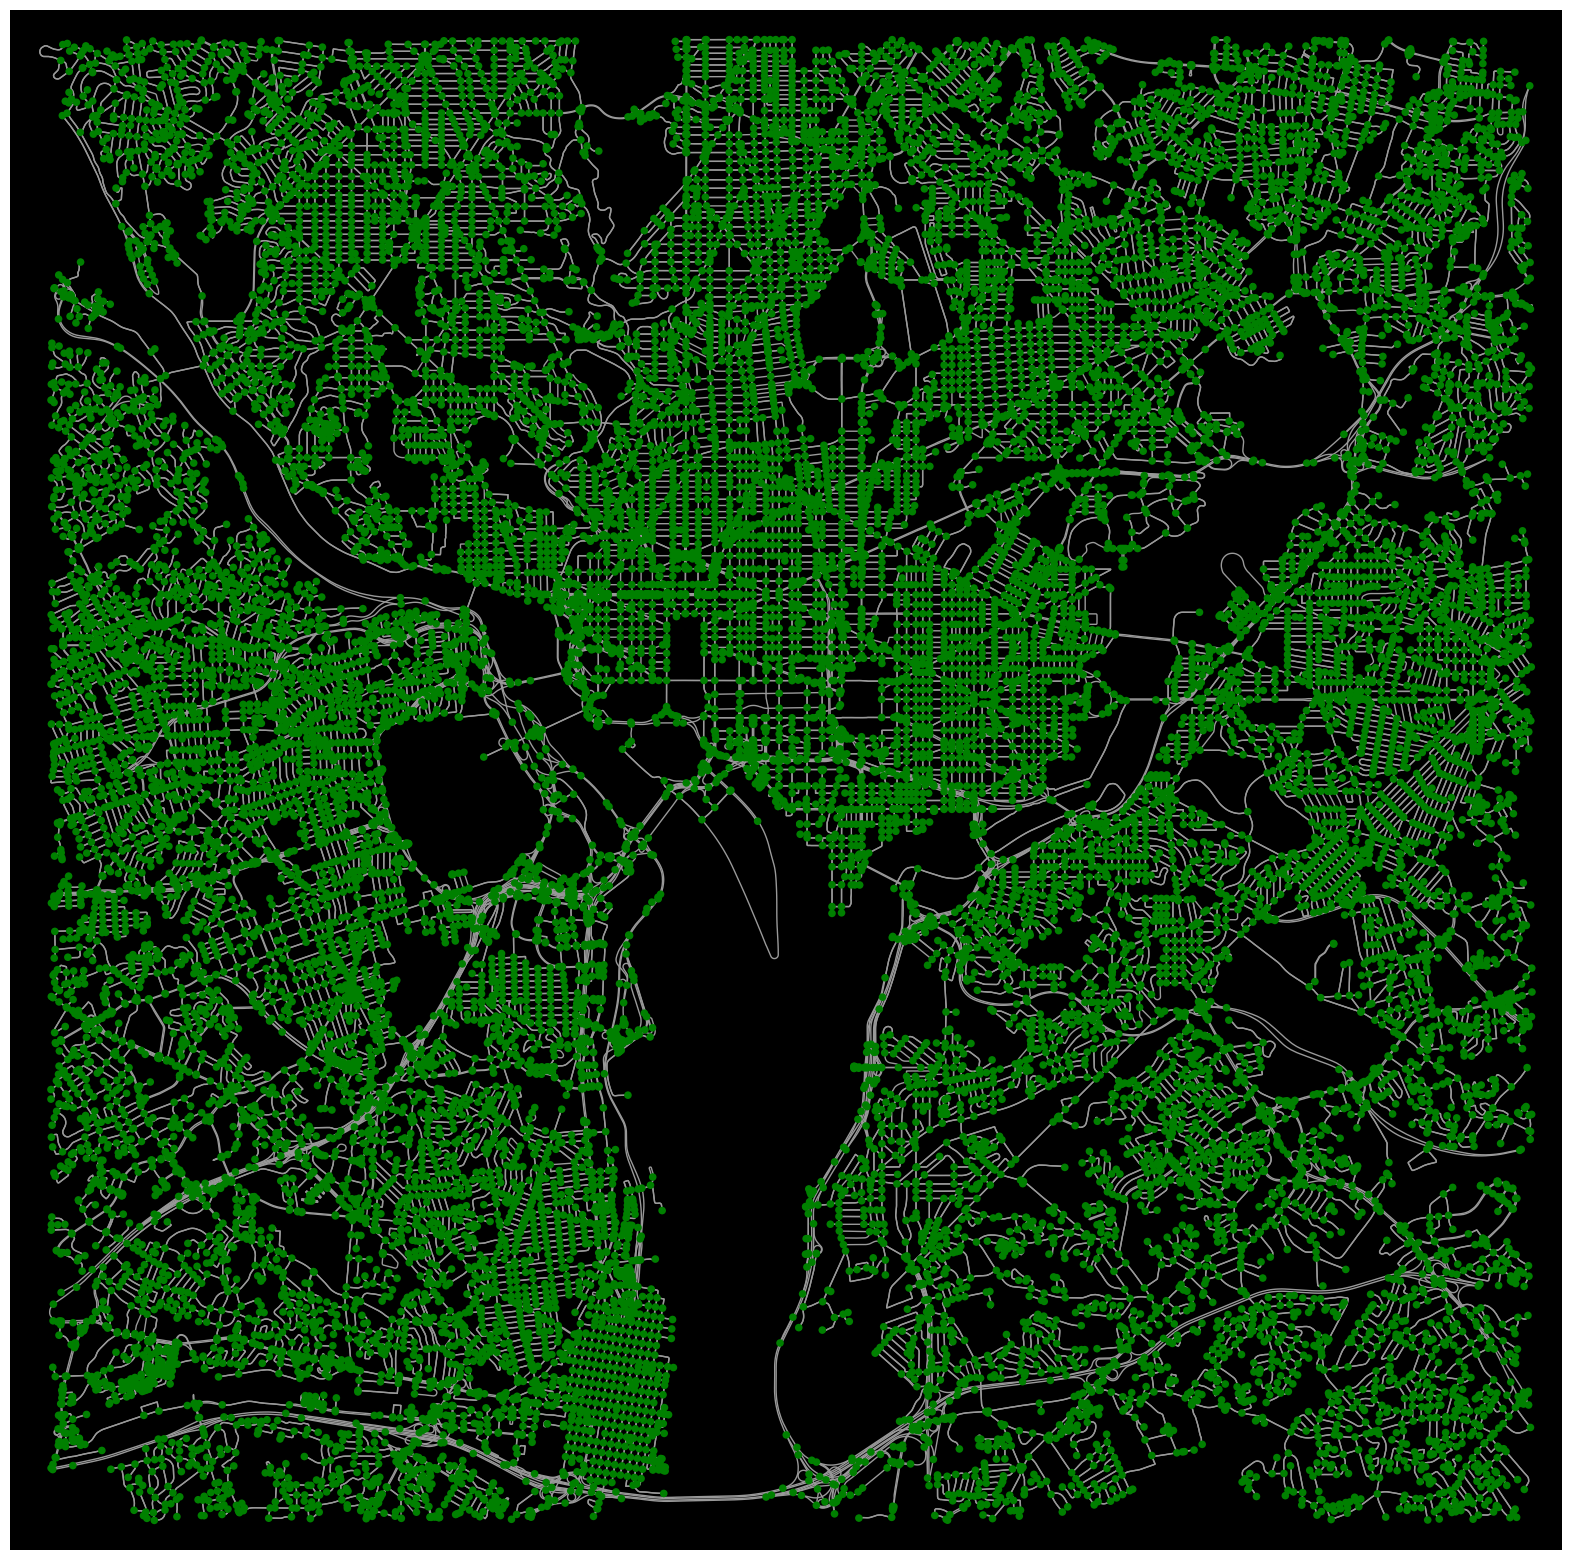

In [8]:
G = ox.graph_from_point(start, dist= 10e3, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
G = ox.add_edge_bearings(G)

fig,ax = ox.plot_graph(G,bgcolor="black", node_size = 30, node_color = 'green', figsize = (30,20))

In [9]:
#ox.basic_stats(G)
print(len(G.edges()))

59540


In [10]:
# Convert edges to DataFrame for better viewing
edges_df = pd.DataFrame([
    {
        'source': u,
        'target': v,
        **data
    }
    for u, v, data in G.edges(data=True)
])

In [11]:
edges_df.head()

,source,target,osmid,oneway,lanes,name,highway,maxspeed,reversed,length,...,speed_kph,travel_time,bearing,ref,bridge,junction,service,access,width,tunnel
0,287905,63755704,"[999712204, 8824926]",False,2,Dawes Avenue,tertiary,25 mph,False,455.820,...,40.2,40.8,236.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,287905,3035949599,468774716,True,3,Leesburg Pike,primary,40 mph,False,210.724,...,64.4,11.8,296.1,VA 7,NaN,NaN,NaN,NaN,NaN,NaN
2,287905,623691150,"[468774721, 468774722, 468774723]",False,"[5, 4]",King Street,primary,35 mph,True,148.789,...,56.3,9.5,118.3,VA 7,NaN,NaN,NaN,NaN,NaN,NaN
3,287910,594321287,"[4681076, 149948461, 468499711]",True,"[4, 3]",Leesburg Pike,primary,40 mph,False,302.679,...,64.4,16.9,303.8,VA 7,yes,NaN,NaN,NaN,NaN,NaN
4,287910,63434666,8803437,True,1,NaN,primary_link,NaN,False,246.280,...,45.8,19.4,324.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now that we defined the graph object around the starting node, and we visualized the nodes and edges, we can easily find the nearest nodes to each of the store locations. lets first figure out where are the stores are located on our graph (what are the nearest nodes on graph that represents the store locations)

In [45]:
start_node = ox.distance.nearest_nodes(G,start[1],start[0])
print(start_node)
node_coords = G.nodes[start_node]
print(node_coords)
print("Node coordinates:", (node_coords['x'], node_coords['y']))
print("Original coordinates:", start)

node_point = (node_coords['y'], node_coords['x'])  # Note the swap for lat/lon
distance = geopy.distance.distance(start, node_point).meters

print(f"Distance between node and original point: {distance:.2f} meters")

49830548
{'y': 38.8792915, 'x': -77.0199015, 'highway': 'traffic_signals', 'street_count': 4}
Node coordinates: (-77.0199015, 38.8792915)
Original coordinates: [ 38.88 -77.02]
Distance between node and original point: 79.12 meters
